In [2]:
import numpy as np
import pandas as pd 

import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10,7

import sys
sys.path.append('../src')

# Chapter 2: Financial Data Structures
___
## Exercises

**2.1** On a series of E-mini S&P 500 futures tick data:
- **(a)** Form tick, volume, and dollar bars. Use the ETF trick to deal with the roll.
- **(b)** Count the number of bars produced by tick, volume, and dollar bars on a
weekly basis. Plot a time series of that bar count. What bar type produces
the most stable weekly count? Why?
- **(c)** Compute the serial correlation of returns for the three bar types. What bar
method has the lowest serial correlation?
- **(d)** Partition the bar series into monthly subsets. Compute the variance of returns
for every subset of every bar type. Compute the variance of those variances.
What method exhibits the smallest variance of variances?
- **(e)** Apply the Jarque-Bera normality test on returns from the three bar types. What method achieves the lowest test statistic?

**2.2** On a series of E-mini S&P 500 futures tick data, compute dollar bars
and dollar imbalance bars. What bar type exhibits greater serial correlation?
Why?

**2.3** On dollar bar series of E-mini S&P 500 futures and Eurostoxx 50 futures:
- **(a)** Apply Section 2.4.2 to compute the {$\hat{\omega}_t$} vector used by the ETF trick. (Hint: You will need FX values for EUR/USD at the roll dates.)
- **(b)** Derive the time series of the S&P 500/Eurostoxx 50 spread.
- **(c)** Confirm that the series is stationary, with an ADF test.

**2.4** Form E-mini S&P 500 futures dollar bars:
- **(a)** Compute Bollinger bands of width 5% around a rolling moving average. Count how many times prices cross the bands out (from within the bands to outside the bands).
- **(b)** Now sample those bars using a CUSUM filter, where {$y_t$} are returns and h = 0.05. How many samples do you get?
- **(c)** Compute the rolling standard deviation of the two-sampled series. Which one is least heteroscedastic? What is the reason for these results?

**2.5** Using the bars from exercise 4:
- **(a)** Sample bars using the CUSUM filter, where {$y_t$} are absolute returns and h = 0.05.
- **(b)** Compute the rolling standard deviation of the sampled bars.
- **(c)** Compare this result with the results from exercise 4. What procedure delivered the least heteroscedastic sample? Why?

### Load Data
___

In [3]:
clean_data_path = '../data/processed/clean_IVE_tickbidask.parq'
#clean_data_path = '../data/processed/clean_WDC_tickbidask.parq'
df = pd.read_parquet(clean_data_path)

In [4]:
df.head()

,price,bid,ask,vol,dollar_vol
date,,,,,
2009-09-28 09:30:00,50.79,50.70,50.79,100,5079.00
2009-09-28 09:30:00,50.71,50.70,50.79,638,32352.98
2009-09-28 09:31:32,50.75,50.75,50.76,100,5075.00
2009-09-28 09:31:33,50.75,50.72,50.75,100,5075.00
2009-09-28 09:31:50,50.75,50.73,50.76,300,15225.00


Plot the montly candlestick plot:

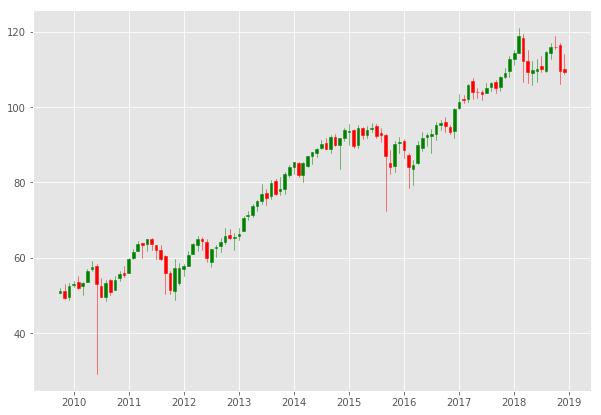

In [5]:
from visualization.candle import plot_candlestick_ohlc

df_ohlc = df.price.resample('1M').ohlc() 

fig, ax = plt.subplots()
plot_candlestick_ohlc(df_ohlc, ax, width=18)

## Solutions

**2.1** On a series of E-mini S&P 500 futures tick data:

**(a)** Form tick, volume, and dollar bars. Use the ETF trick to deal with the roll.

In [12]:
from features.bars import tick_bar
from features.bars import volume_bar
from features.bars import dollar_bar

In [17]:
minute_df = df.price.resample('min').ohlc().dropna()

m = 10
tick_df = tick_bar(df, m)

m = 1_000
vol_df = volume_bar(df, m)

m = 100_000
dollar_df = dollar_bar(df, m)

In [19]:
print(f"{df.shape} {minute_df.shape} {tick_df.shape} {vol_df.shape} {dollar_df.shape} {tick_df.index[0]}, {tick_df.index[-1]}")

(1462548, 5) (546418, 4) (146255, 5) (420315, 6) (366036, 6) 2009-09-28 09:30:00, 2018-11-21 15:59:55


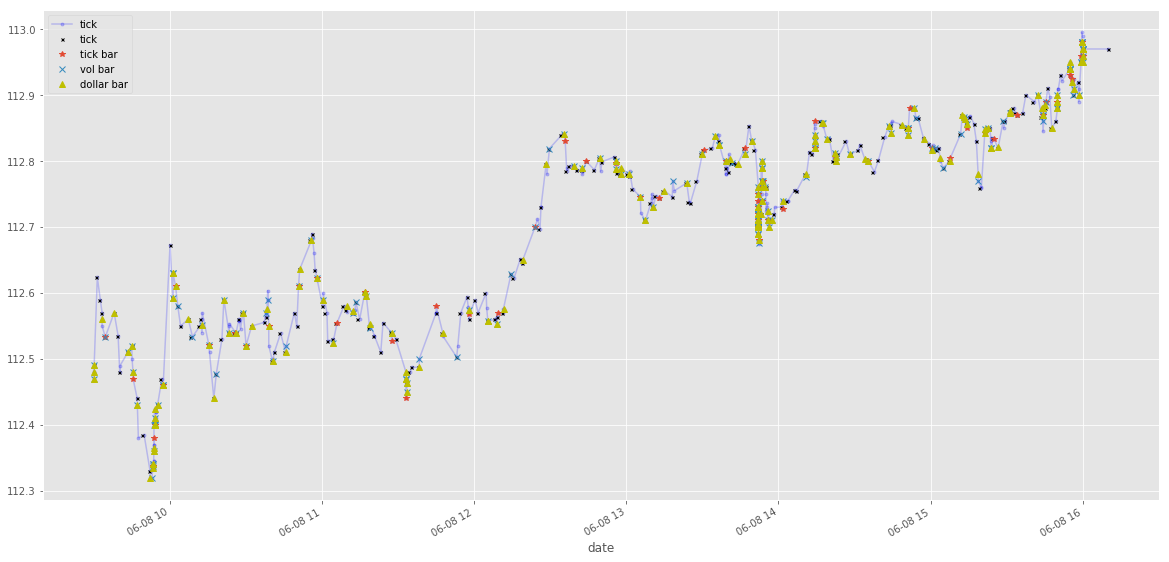

In [20]:
s_date='2018-06-08 8:00:00'
e_date='2018-06-08 17:00:00'
plt.figure(figsize=(20,10))
df.loc[s_date:e_date].price.plot(marker='o',
                                 ms=3,
                                 color='b',
                                 alpha=0.2,
                                 label='tick')

minute_df.open.loc[s_date:e_date].plot(marker='x',
                                       ms=3,
                                       ls='',
                                       color='k',
                                       label='tick')
tick_df.loc[s_date:e_date].price.plot(marker='*',
                                      ls='',
                                      label='tick bar')
vol_df.loc[s_date:e_date].price.plot(marker='x',
                                     ls='',
                                     label='vol bar')
dollar_df.loc[s_date:e_date].price.plot(marker='^',
                                        ls='',
                                        color='y',
                                        label='dollar bar')
plt.legend()

- **(b)** Count the number of bars produced by tick, volume, and dollar bars on a weekly basis. Plot a time series of that bar count. What bar type produces the most stable weekly count? Why?

In [21]:
weekly_tick_count = tick_df.price.resample('1W').count()
weekly_vol_count = vol_df.price.resample('1W').count()
weekly_dollar_count = dollar_df.price.resample('1W').count()

In [22]:
count_df = pd.DataFrame(columns=['count_mean','count_std'], index=['tick', 'vol', 'dollar'])
count_df.loc['tick'] = [weekly_tick_count.mean(), weekly_tick_count.std()]
count_df.loc['vol'] = [weekly_vol_count.mean(), weekly_vol_count.std()]
count_df.loc['dollar'] = [weekly_dollar_count.mean(), weekly_dollar_count.std()]
count_df

,count_mean,count_std
tick,305.973,154.337
vol,879.32,428.97
dollar,765.766,456.599


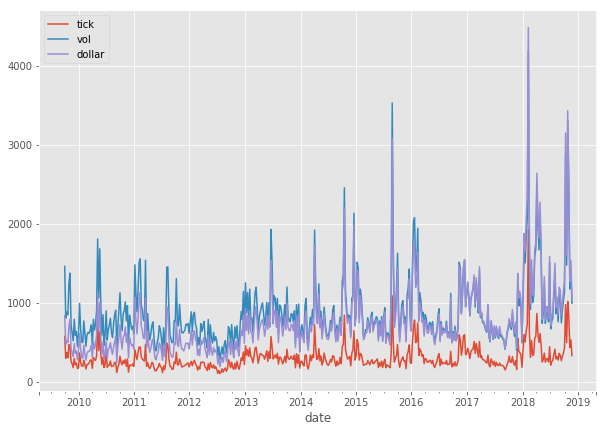

In [23]:
fig, ax = plt.subplots(1)
weekly_tick_count.plot(ax=ax)
weekly_vol_count.plot(ax=ax)
weekly_dollar_count.plot(ax=ax)
ax.legend(["tick", "vol", 'dollar'])

In [24]:
def scale(s):
    return (s-s.min())/(s.max()-s.min())

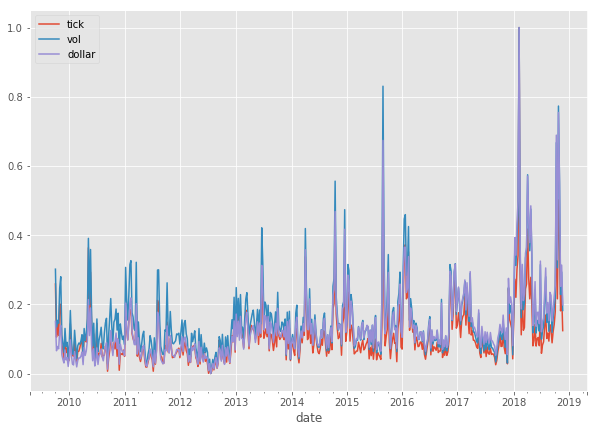

In [25]:
fig, ax = plt.subplots(1)
scale(weekly_tick_count).plot(ax=ax)
scale(weekly_vol_count).plot(ax=ax)
scale(weekly_dollar_count).plot(ax=ax)
ax.legend(["tick", "vol", 'dollar'])

**(c)** Compute the serial correlation of returns for the three bar types. What bar method has the lowest serial correlation?

In [26]:
# log returns
tick_returns = np.log(tick_df.price).diff().dropna()
vol_returns = np.log(vol_df.price).diff().dropna()
dollar_returns = np.log(dollar_df.price).diff().dropna()

In [27]:
returns_corr_df = pd.DataFrame(data={'returns_autocorr':[tick_returns.autocorr(),  
                                                         vol_returns.autocorr(), 
                                                         dollar_returns.autocorr()]
                                    },
                               index=['tick', 'vol', 'dollar'])
returns_corr_df

,returns_autocorr
tick,0.122195
vol,-0.172195
dollar,0.089165


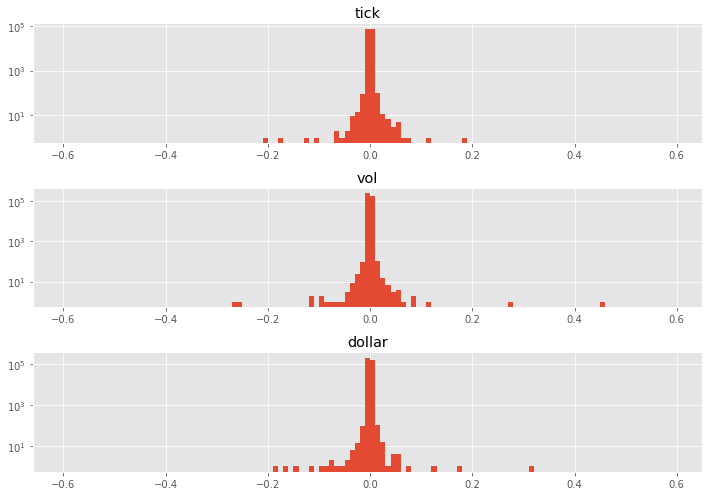

In [28]:
bins = np.arange(-0.6,0.6,0.01)
fig, ax = plt.subplots(3,1)
ax[0].hist(tick_returns, bins=bins)
ax[0].set_title('tick')
ax[1].hist(vol_returns, bins=bins)
ax[1].set_title('vol')
ax[2].hist(dollar_returns, bins=bins)
ax[2].set_title('dollar')
[a.set_yscale('log') for a in ax]
fig.tight_layout()

In [ ]:
import statsmodels.api as sm
fig, ax = plt.subplots(3,1)
sm.graphics.tsa.plot_acf(tick_returns, lags=20, ax=ax[0], title='tick')
sm.graphics.tsa.plot_acf(vol_returns, lags=20, ax=ax[1], title='vol')
sm.graphics.tsa.plot_acf(dollar_returns, lags=20, ax=ax[2], title='dollar')
fig.tight_layout()

**(d)** Partition the bar series into monthly subsets. Compute the variance of returns for every subset of every bar type. Compute the variance of those variances. What method exhibits the smallest variance of variances?

In [29]:
#monthly_ticks_returns_var = tick_returns.resample('M').var()
monthly_tick_returns_var = tick_returns.resample('M').var()
monthly_vol_returns_var = vol_returns.resample('M').var()
monthly_dollar_retuns_var = dollar_returns.resample('M').var()

In [30]:
monthly_ret_var_df = pd.DataFrame(data={'monthly_returns_var' : [monthly_tick_returns_var.var(),  
                                                                 monthly_vol_returns_var.var(),
                                                                 monthly_dollar_retuns_var.var()]
                                       },
                                  index=['tick', 'vol', 'dollar'])
monthly_ret_var_df

,monthly_returns_var
tick,7.402554e-11
vol,8.509820e-11
dollar,6.566772e-11


**(e)** Apply the Jarque-Bera normality test on returns from the three bar types. What method achieves the lowest test statistic?

In [31]:
from scipy.stats import jarque_bera

In [32]:
jb_value_tick, _ = jarque_bera(tick_returns)
jb_value_vol, _ = jarque_bera(vol_returns)
jb_value_dollar, _ = jarque_bera(dollar_returns)

In [33]:
jb_test_df = pd.DataFrame(data={'jarque_bera_results' : [jb_value_tick,  
                                                         jb_value_vol,
                                                         jb_value_dollar]
                               },
                          index=['tick', 'vol', 'dollar'])
jb_test_df

,jarque_bera_results
tick,9.910805e+10
vol,3.012536e+13
dollar,5.834302e+12


All the comparations

In [35]:
pd.concat([count_df, returns_corr_df, monthly_ret_var_df, jb_test_df],axis=1)

,count_mean,count_std,returns_autocorr,monthly_returns_var,jarque_bera_results
tick,305.973,154.337,0.122195,7.402554e-11,9.910805e+10
vol,879.32,428.97,-0.172195,8.509820e-11,3.012536e+13
dollar,765.766,456.599,0.089165,6.566772e-11,5.834302e+12


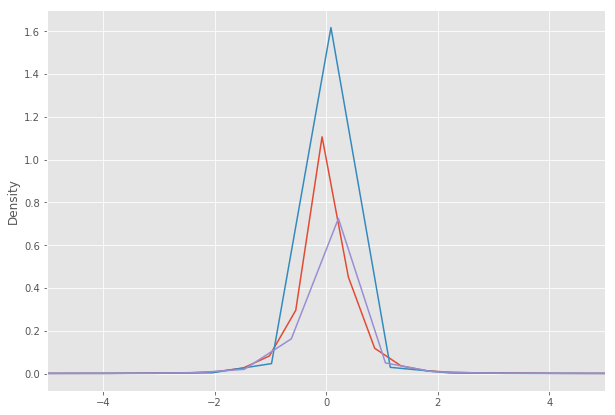

In [36]:
tick_standard = (tick_returns - tick_returns.mean()) / tick_returns.std()
volume_standard = (vol_returns - vol_returns.mean()) / vol_returns.std()
dollar_standard = (dollar_returns - dollar_returns.mean()) / dollar_returns.std()

fig, ax = plt.subplots(1,1)
tick_standard.plot.density(ax=ax,
                           xlim=(-5,5))
volume_standard.plot.density(ax=ax,
                             xlim=(-5,5))
dollar_standard.plot.density(ax=ax,
                             xlim=(-5,5))

/Users/fernando/python_venv/python36_ml/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(-5, 5)

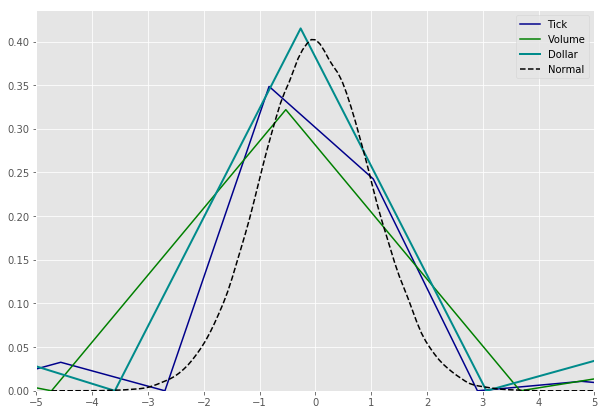

In [37]:
import seaborn as sns

fig, ax = plt.subplots()
#sns.kdeplot(time_standard, label="Time", bw=0.30, color='darkred')
sns.kdeplot(tick_standard, 
            ax=ax,
            label="Tick", 
            bw=0.25,
            color='darkblue')
sns.kdeplot(volume_standard,
            ax=ax,
            label="Volume",
            bw=0.25,
            color='green')
sns.kdeplot(dollar_standard,
            ax=ax,
            label="Dollar",
            bw=0.25,
            linewidth=2,
            color='darkcyan')
sns.kdeplot(np.random.normal(size=len(tick_standard)),
            ax=ax,
            label="Normal",
            color='black',
            linestyle="--")
ax.set_xticks(range(-5, 6))
ax.set_xlim(-5, 5)

___

**2.2** On a series of E-mini S&P 500 futures tick data, compute dollar bars
and dollar imbalance bars. What bar type exhibits greater serial correlation?
Why?

In [86]:
# implement dollar imbalance bars

___

**2.3** On dollar bar series of E-mini S&P 500 futures and Eurostoxx 50 futures:
- **(a)** Apply Section 2.4.2 to compute the {$\hat{\omega}_t$} vector used by the ETF trick. (Hint: You will need FX values for EUR/USD at the roll dates.)
- **(b)** Derive the time series of the S&P 500/Eurostoxx 50 spread.
- **(c)** Confirm that the series is stationary, with an ADF test.

In [ ]:
# Don't have the eurostoxx 50 data

___

**2.4** Form E-mini S&P 500 futures dollar bars:
- **(a)** Compute Bollinger bands of width 5% around a rolling moving average. Count how many times prices cross the bands out (from within the bands to outside the bands).
- **(b)** Now sample those bars using a CUSUM filter, where {$y_t$} are returns and h = 0.05. How many samples do you get?
- **(c)** Compute the rolling standard deviation of the two-sampled series. Which one is least heteroscedastic? What is the reason for these results?

**(a)** Compute Bollinger bands of width 5% around a rolling moving average. Count how many times prices cross the bands out (from within the bands to outside the bands).

In [38]:
m = 100_000
dollar_df = dollar_bar(df, m)

Traditional Bollinger Bands consist of a N-period moving average (MA), an upper band at K times an N-period standard deviation  above the moving average (MA + Kσ) and a lower band at K times an N-period standard deviation below the moving average (MA − Kσ). , a typical values for N and K are 20 and 2

In [39]:
N = 20
K = 2
ma = dollar_df.price.rolling(N).mean()
sigma = dollar_df.price.rolling(N).std()
upper_band = ma + K*sigma
lower_band = ma - K*sigma

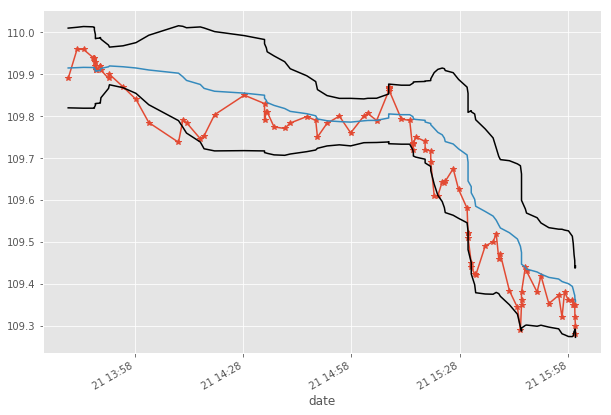

In [40]:
fig, ax = plt.subplots(1)
dollar_df.iloc[-100:].price.plot(ax=ax, marker='*')
ma.iloc[-100:].plot(ax=ax)
upper_band.iloc[-100:].plot(ax=ax, color='k')
lower_band.iloc[-100:].plot(ax=ax, color='k')

The exercise says compute Bollinger bands of width 5% around a rolling moving average. 

In [41]:
N = 20
ma = dollar_df.price.rolling(N).mean()
price_pct = 0.001
upper_band = ma + ma*price_pct
lower_band = ma - ma*price_pct
bb_dataframe = pd.concat([dollar_df.price, ma, upper_band, lower_band], axis=1).dropna()
bb_dataframe.columns=['price','ma','upper_band','lower_band']

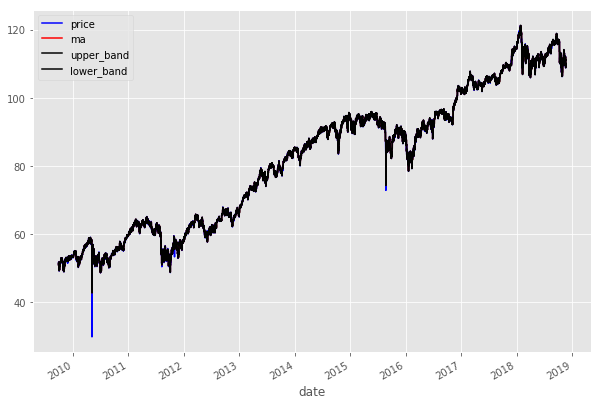

In [42]:
fig, ax = plt.subplots(1)
bb_dataframe.plot(ax=ax, color=['b','r', 'k', 'k'])

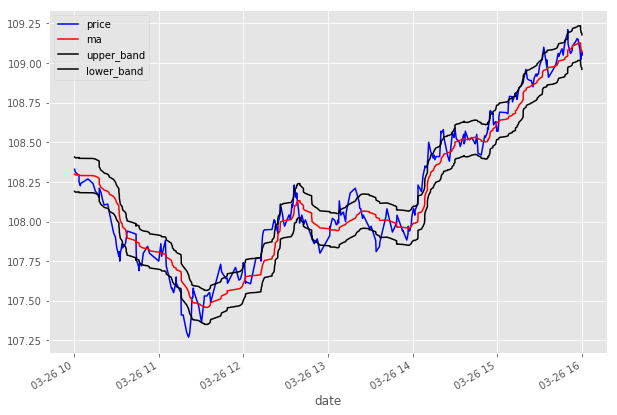

In [56]:
s_date='2018-03-26 10'
e_date='2018-03-26 16'

fig, ax = plt.subplots(1)
bb_dataframe.loc[s_date:e_date].plot(ax=ax, color=['b','r', 'k', 'k'])

Count how many times prices cross the bands out (from within the bands to outside the bands).

In [44]:
dollar_df[dollar_df.price > upper_band].shape

(66036, 6)

In [45]:
dollar_df[dollar_df.price < lower_band].shape  

(63996, 6)

In [46]:
def get_up_cross(df):
    crit1 = df.price.shift(1) < df.upper_band.shift(1)  
    crit2 = df.price > df.upper_band
    return df.price[(crit1) & (crit2)]

def get_down_cross(df): 
    crit1 = df.price.shift(1) > df.lower_band.shift(1) 
    crit2 = df.price < df.lower_band
    return df.price[(crit1) & (crit2)]

bb_down = get_down_cross(bb_dataframe)
bb_up = get_up_cross(bb_dataframe) 

In [47]:
bb_down.shape

(11192,)

In [48]:
bb_up.shape

(11461,)

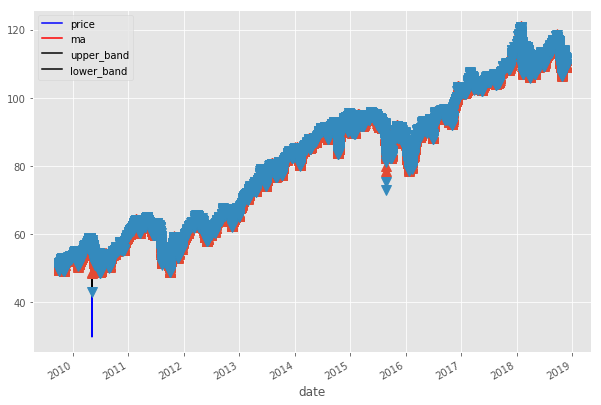

In [49]:
fig, ax = plt.subplots(1)
bb_dataframe.plot(ax=ax, color=['b','r', 'k', 'k'])
bb_up.plot(ax=ax, marker='^', ms=10, ls='')
bb_down.plot(ax=ax, marker='v', ms=10, ls='')

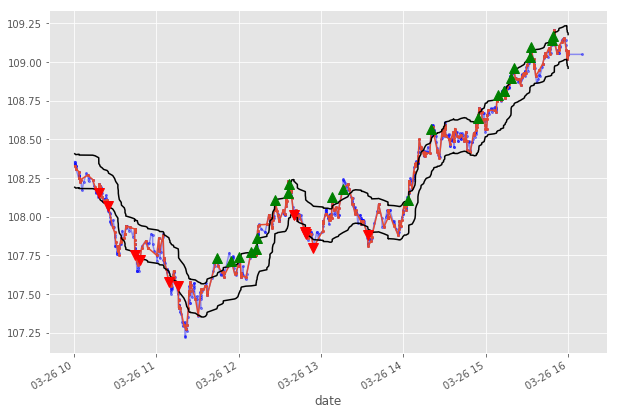

In [50]:
s_date='2018-03-26 10'
e_date='2018-03-26 16'

fig, ax = plt.subplots(1)
df.loc[s_date:e_date].price.plot(ax=ax, color='b', marker='o', alpha=0.4, ms=2)

bb_dataframe.loc[s_date:e_date].price.plot(ax=ax, marker='o', ms=2)
bb_dataframe.loc[s_date:e_date].upper_band.plot(ax=ax, color='k')
bb_dataframe.loc[s_date:e_date].lower_band.plot(ax=ax, color='k')
bb_up.loc[s_date:e_date].plot(ax=ax, color='g', marker='^', ms=10, ls='')
bb_down.loc[s_date:e_date].plot(ax=ax, color='r', marker='v', ms=10, ls='')

___

**2.5** Using the bars from exercise 4:
- **(a)** Sample bars using the CUSUM filter, where {$y_t$} are absolute returns and h = 0.05.
- **(b)** Compute the rolling standard deviation of the sampled bars.
- **(c)** Compare this result with the results from exercise 4. What procedure delivered the least heteroscedastic sample? Why?